In [43]:
import tensorflow as tf
import pandas as pd
import tensorflow_datasets as tfds
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
def load_data():
    print(" Loading the dataset")
    (ds_train, ds_val, ds_test), ds_info = tfds.load(
        'gigaword',
        split=['train', 'validation', 'test'],
        shuffle_files=True,
        as_supervised=True,
        with_info=True,
    )
    return ds_train, ds_val, ds_test

In [4]:
ds_train, _, _ = load_data()

 Loading the dataset


The Gigaword dataset has been already cleaned, normalized, and tokenized using
the StanfordNLP tokenizer. All the data is converted into lowercase and normalized
using the StanfordNLP tokenizer

### Preprocessing

This method checks to see if a subword tokenizer is saved and loads it. If no
tokenizer exists on disk, it creates one by feeding in the articles and summaries
combined.

In [5]:
def get_tokenizer(data, file="gigaword32k.enc"):
    if os.path.exists(file+".subwords"):
        #check if the tokenizer already exists
        tokenizer = tfds.deprecated.text.SubwordTextEncoder.load_from_file(file)
    else:
        tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(((art.numpy() + b" " + smm.numpy()) for art, smm in data)
                                                                            ,target_vocab_size=2**15) # End tokenizer construction
        tokenizer.save_to_file(file) # save for future iterations
    print("Tokenizer ready. Total vocabulary size: ", tokenizer.vocab_size)
    return tokenizer

In [6]:
tokenizer = get_tokenizer(ds_train)

Tokenizer ready. Total vocabulary size:  32897


In [7]:
# Test tokenizer
txt = "Coronavirus spread surprised everyone"
for ts in tokenizer.encode(txt.lower()):
    print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

16166 ----> corona
2342 ----> virus 
1980 ----> spread 
7546 ----> surprised 
21092 ----> everyone


In [8]:
# add start and end of sentence tokens
start = tokenizer.vocab_size + 1 
end = tokenizer.vocab_size
print(start, end)

32898 32897


In [9]:
# Setup tokenization methods
from tensorflow.keras.preprocessing import sequence

def encode(article, summary, start=start, end=end, art_max_len=128, smry_max_len=50):
    art_tokens = tokenizer.encode(article.numpy())
    
    # vectorize article
    if len(art_tokens) > art_max_len:
        art_tokens = art_tokens[:art_max_len]
        
    #padding with 0 till the max length of article   
    art_enc = sequence.pad_sequences([art_tokens], padding='post',maxlen=art_max_len).squeeze()
    
    # vectorize summary
    #adding start token
    smry_tokens = [start] + tokenizer.encode(summary.numpy())
    
    if len(smry_tokens) > smry_max_len:
        tokens = tokens[:smry_max_len]
        
    #adding end token
    smry_tokens = smry_tokens + [end]
    
    #padding with 0 till the max length of summary 
    smry_enc = sequence.pad_sequences([smry_tokens], padding='post', maxlen=smry_max_len).squeeze()
  
    return art_enc, smry_enc

# function to apply the encode on Tensorflow dataset
# check link below
# https://stackoverflow.com/questions/55806857/is-it-possible-to-map-a-numpy-function-to-tf-data-dataset
def tf_encode(article, summary):
    art_enc, smry_enc = tf.py_function(encode, [article, summary], [tf.int64, tf.int64])
    
    art_enc.set_shape([None])
    smry_enc.set_shape([None])

    return art_enc, smry_enc

In [22]:
# dataset is 3.8M samples, we will choose only 100k sample from it and set batch size equal to 64
BUFFER_SIZE = 100000 
BATCH_SIZE = 64

train = ds_train.take(BUFFER_SIZE) 
train_dataset = train.map(tf_encode)
train_dataset = train_dataset.batch(BATCH_SIZE,drop_remainder=True)

now we have Train Data

In [24]:
# Encoder
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
        super(Encoder, self).__init__()
        
        self.batch_size = batch_size
        self.enc_units = enc_units
        
        # Shared embedding layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)
        
        self.bigru = layers.Bidirectional(layers.GRU(self.enc_units,return_sequences=True,
                                              return_state=True,recurrent_initializer='glorot_uniform'),merge_mode='concat')
        self.relu = layers.Dense(self.enc_units, activation='relu')
        
    def call(self, x, hidden):
        x = self.embedding(x) 
        
        output, forward_state, backward_state = self.bigru(x, initial_state = hidden)
        
        hidden_states = tf.concat([forward_state, backward_state],axis=1)
        
        output_state = self.relu(hidden_states)
        
        return output, output_state
    
    # init hidden state
    def initialize_hidden_state(self):
        return [tf.zeros((self.batch_size, self.enc_units)) for i in range(2)]

In [25]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, decoder_hidden, enc_output):

        query = decoder_hidden 
        values = enc_output
        
        query_with_time_axis = tf.expand_dims(query, 1)
    
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
    
        attention_weights = tf.nn.softmax(score, axis=1)
    
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
    
        return context_vector, attention_weights

In [26]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
        super(Decoder, self).__init__()
        
        self.batch_size = batch_size
        self.dec_units = dec_units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                                  mask_zero=True)
        
        self.gru = tf.keras.layers.GRU(self.dec_units,return_sequences=True,return_state=True,
                                       recurrent_initializer='glorot_uniform')
        
        self.fc1 = tf.keras.layers.Dense(vocab_size, activation='softmax', name='fc1')

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        
        context_vector, attention_weights = self.attention(hidden, enc_output)

        x = self.embedding(x)
    
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    
        output, state = self.gru(x)

        output = tf.reshape(output, (-1, output.shape[2]))
        
        x = self.fc1(output)
        
        return x, state, attention_weights

In [28]:
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=False)


#loss function masks our predictions with the labels, so
#padded positions on the label are also removed from the predictions, and we only
#compute our loss using the non zero elements on both the label and predictions.
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    loss = loss_object(real, pred)
    loss *= mask
    return tf.reduce_mean(loss)

In [29]:
@tf.function
def train_step(inp, targ, enc_hidden, max_gradient_norm=5):
    loss = 0
    with tf.GradientTape() as tape:
        
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([start] * BATCH_SIZE, 1)
        
        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input,dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)
            
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    
    gradients = tape.gradient(loss, variables)
    # Gradient clipping
    clipped_gradients, _ = tf.clip_by_global_norm(gradients, max_gradient_norm)
    optimizer.apply_gradients(zip(clipped_gradients, variables))
    return batch_loss

In [35]:
steps_per_epoch = BUFFER_SIZE // BATCH_SIZE
print(f"Steps per Epoch = {steps_per_epoch}")

#define our hyperparameters
EPOCHS = 2
vocab_size = end + 2
embedding_dim = 128
units = 256 

In [34]:
# init model
encoder = Encoder(vocab_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_size, embedding_dim, units, BATCH_SIZE)

# Learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.001,decay_steps=steps_per_epoch*(EPOCHS/2)
                                                             ,decay_rate=2,staircase=False)
optimizer = tf.keras.optimizers.Adam(lr_schedule)

In [36]:
print("Starting Training. Total number of steps / epoch: ", steps_per_epoch)
for epoch in range(EPOCHS):
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    for (batch, (art, smry)) in enumerate(train_dataset.take(steps_per_epoch)):
        batch_loss = train_step(art, smry, enc_hidden)
        total_loss += batch_loss
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.6f}'.format(epoch + 1, batch,batch_loss.numpy())) # end print
    print('Epoch {} Loss {:.6f}'.format(epoch + 1, total_loss / steps_per_epoch))

Starting Training. Total number of steps / epoch:  1562
Epoch 1 Batch 0 Loss 2.128992
Epoch 1 Batch 100 Loss 1.686817
Epoch 1 Batch 200 Loss 1.515625
Epoch 1 Batch 300 Loss 1.483473
Epoch 1 Batch 400 Loss 1.411534
Epoch 1 Batch 500 Loss 1.359428
Epoch 1 Batch 600 Loss 1.448738
Epoch 1 Batch 700 Loss 1.455730
Epoch 1 Batch 800 Loss 1.359153
Epoch 1 Batch 900 Loss 1.423862
Epoch 1 Batch 1000 Loss 1.381095
Epoch 1 Batch 1100 Loss 1.362542
Epoch 1 Batch 1200 Loss 1.281053
Epoch 1 Batch 1300 Loss 1.306504
Epoch 1 Batch 1400 Loss 1.351558
Epoch 1 Batch 1500 Loss 1.353919
Epoch 2 Batch 0 Loss 1.268424
Epoch 2 Batch 100 Loss 1.346206
Epoch 2 Batch 200 Loss 1.359361
Epoch 2 Batch 300 Loss 1.403513
Epoch 2 Batch 400 Loss 1.303977
Epoch 2 Batch 500 Loss 1.384593
Epoch 2 Batch 600 Loss 1.273311
Epoch 2 Batch 700 Loss 1.263464
Epoch 2 Batch 800 Loss 1.326787
Epoch 2 Batch 900 Loss 1.265490
Epoch 2 Batch 1000 Loss 1.398102
Epoch 2 Batch 1100 Loss 1.345067
Epoch 2 Batch 1200 Loss 1.274714
Epoch 2 Bat

In [45]:
encoder.summary()

Model: "encoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      multiple                  4211072   
_________________________________________________________________
bidirectional_1 (Bidirection multiple                  592896    
_________________________________________________________________
dense_4 (Dense)              multiple                  131328    
Total params: 4,935,296
Trainable params: 4,935,296
Non-trainable params: 0
_________________________________________________________________


In [46]:
decoder.summary()

Model: "decoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      multiple                  4211072   
_________________________________________________________________
gru_3 (GRU)                  multiple                  689664    
_________________________________________________________________
fc1 (Dense)                  multiple                  8455043   
_________________________________________________________________
bahdanau_attention_1 (Bahdan multiple                  197377    
Total params: 13,553,156
Trainable params: 13,553,156
Non-trainable params: 0
_________________________________________________________________


# Generating Summary

## Greedy algorithm

In [47]:
BATCH_SIZE = 1
# Create encoder and decoder objects
encoder_1 = Encoder(vocab_size, embedding_dim, units, BATCH_SIZE)
decoder_1 = Decoder(vocab_size, embedding_dim, units, BATCH_SIZE)

In [48]:
# function for plotting the attention weights
def plot_attention(attention, article, summary):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    # for scales
    ax.matshow(attention, cmap='cividis')
    fontdict = {'fontsize': 14}
    ax.set_xticklabels([''] + article, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + summary, fontdict=fontdict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

In [56]:
def greedy_search(article,art_max_len = 128,smry_max_len = 50):
    # To store attention plots of the output
    attention_plot = np.zeros((smry_max_len, art_max_len))
    #preprocessing
    tokens = tokenizer.encode(article) 
    if len(tokens) > art_max_len:
        tokens = tokens[:art_max_len]

    inputs = sequence.pad_sequences([tokens], padding='post',
                                 maxlen=art_max_len).squeeze()
    inputs = tf.expand_dims(tf.convert_to_tensor(inputs), 0)
    
    # output summary tokens will be stored in this
    # feed to Model
    summary = ''

    hidden = [tf.zeros((1, units)) for i in range(2)] #BiRNN
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([start], 0)

    for t in range(smry_max_len):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        if predicted_id == end:
            return summary, article, attention_plot
        
        # storing the attention weights to plot later on
        # to print attention plot
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        
        #adding output token to summary
        summary += tokenizer.decode([predicted_id])
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return summary, article, attention_plot

In [57]:
def summarize(article, algo='greedy'):
    if algo == 'greedy':
        summary, article, attention_plot = greedy_search(article)
    else:
        print("Algorithm {} not implemented".format(algo))
        return
    print('Input: %s' % (article))
    print('** Predicted Summary: {}'.format(summary))
    attention_plot =  attention_plot[:len(summary.split(' ')), :len(article.split(' '))]
    plot_attention(attention_plot, article.split(' '),
    summary.split(' '))

Input: president georgi parvanov summoned france 's ambassador on wednesday in a show of displeasure over comments from french president \jacques chirac chiding east european nations for their support of washington on the issue of iraq .
** Predicted Summary: eu to be says u.s. to be in iraq


C:\Users\Osama Ismael\AppData\Local\Temp\ipykernel_11612\550650750.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + article, fontdict=fontdict, rotation=90)
C:\Users\Osama Ismael\AppData\Local\Temp\ipykernel_11612\550650750.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + summary, fontdict=fontdict)


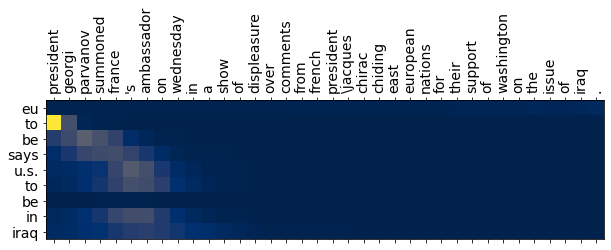

In [58]:
txt = "president georgi parvanov summoned france 's ambassador on wednesday in a show of displeasure over comments from french president \jacques chirac chiding east european nations for their support of washington on the issue of iraq ."
summarize(txt.lower())

Input: charles kennedy , leader of britain's third-ranked liberal democrats ,announced saturday he was quitting with immediate effect and would not standin a new leadership election . us president george w. bush on saturday called forextending tax cuts adopted in his first term , which he said had bolstered economicgrowth.
** Predicted Summary: u.s. president to be in new year in china


C:\Users\Osama Ismael\AppData\Local\Temp\ipykernel_11612\550650750.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + article, fontdict=fontdict, rotation=90)
C:\Users\Osama Ismael\AppData\Local\Temp\ipykernel_11612\550650750.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + summary, fontdict=fontdict)


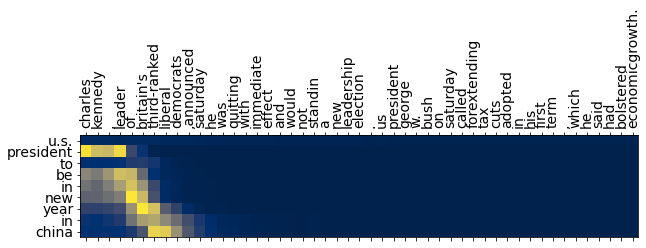

In [59]:
txt = "charles kennedy , leader of britain's third-ranked liberal democrats ,\
announced saturday he was quitting with immediate effect and would not stand\
in a new leadership election . us president george w. bush on saturday called for\
extending tax cuts adopted in his first term , which he said had bolstered economic\
growth."
summarize(txt.lower())